In [3]:

from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from dataloader import sceneflow_collector as lt
from dataloader import kitti_loader as DA
from models.deeppruner import DeepPruner
from loss_evaluation import loss_evaluation
#from tensorboardX import SummaryWriter
import skimage
import time
import logging
from models.config import config as config_args
from setup_logging import setup_logging

model = DeepPruner()

model = nn.DataParallel(model)
model.cuda()
state_dict = torch.load('/notebooks/DeepPruner-best-kitti.tar')
model.load_state_dict(state_dict['state_dict'], strict=True)

TrainImgLoader = torch.utils.data.DataLoader(
    DA.KITTILoader(False),
    batch_size=1, shuffle=False, num_workers=8, drop_last=False)
batch = iter(TrainImgLoader).next()
imgL  = batch[0]
imgR = batch[1]
disp_L = batch[2]
pad_w = batch[3]
pad_h =  batch[4]
def test(imgL, imgR, disp_L , pad_h , pad_w):

    model.eval()
    with torch.no_grad():
        imgL = Variable(torch.FloatTensor(imgL))
        imgR = Variable(torch.FloatTensor(imgR))
        disp_L = Variable(torch.FloatTensor(disp_L))

        imgL, imgR, disp_true = imgL.cuda(), imgR.cuda(), disp_L.cuda()

        mask = disp_true < 192
        mask.detach_()

        if len(disp_true[mask]) == 0:
            logging.info("invalid GT disaprity...")
            return 0, 0

        #optimizer.zero_grad()

        result = model(imgL, imgR)
        output = []
        for ind in range(len(result)):
            output.append(result[ind][:, pad_h:, pad_w:])
        result = output

        #loss, output_disparity = loss_evaluation(result, disp_true, mask, 8)
    return result
A = test(imgL, imgR, disp_L , pad_h , pad_w)

IndexError: too many indices for tensor of dimension 2

In [12]:
import matplotlib.pyplot as plot
#print(len(A))
plot.figure(figsize=(20,30))
plot.imshow(A[4].squeeze(0).detach().cpu().numpy(), cmap='gray')


IndexError: list index out of range

<Figure size 1440x2160 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


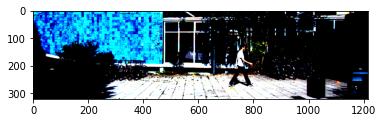

In [6]:
plot.imshow(imgL.squeeze(0).permute(1,2,0).detach().cpu().numpy(), cmap='gray')

In [3]:
from PIL import Image
from dataloader import preprocess


from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from dataloader import sceneflow_collector as lt
from dataloader import kitti_loader as DA
from models.deeppruner import DeepPruner
from loss_evaluation import loss_evaluation
#from tensorboardX import SummaryWriter
import skimage
import time
import logging
from models.config import config as config_args
from setup_logging import setup_logging

model = DeepPruner()

model = nn.DataParallel(model)
model.cuda()
#state_dict = torch.load('/notebooks/DeepPruner-best-kitti.tar')
state_dict = torch.load('/notebooks/E2E/pretrained/dp/E2E_30.tar')
model.load_state_dict(state_dict['state_dict'], strict=True)





imgL = np.asarray(Image.open('/notebooks/dataset/training/image_2/000003.png'))
imgR = np.asarray(Image.open('/notebooks/dataset/training/image_3/000003.png'))
print(imgL.shape)

processed = preprocess.get_transform()
imgL = processed(imgL).numpy()
imgR = processed(imgR).numpy()

imgL = np.reshape(imgL, [1, 3, imgL.shape[1], imgL.shape[2]])
imgR = np.reshape(imgR, [1, 3, imgR.shape[1], imgR.shape[2]])

w = imgL.shape[3]
h = imgL.shape[2]
dw = int(64 - (w%64 + (w%64==0)*64))
dh = int(64 - (h%64 + (h%64==0)*64))

top_pad = dh
left_pad = dw
imgL = np.lib.pad(imgL, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)
imgR = np.lib.pad(imgR, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)

model.eval()
with torch.no_grad():
    imgL = Variable(torch.FloatTensor(imgL))
    imgR = Variable(torch.FloatTensor(imgR))
    imgL, imgR = imgL.cuda(), imgR.cuda()

    refined_disparity = model(imgL, imgR)
refined_disparity = refined_disparity[0].squeeze()[ top_pad:, :-left_pad].data.cpu().numpy() 
# print(refined_disparity)
print(refined_disparity)
print(np.min(refined_disparity))
print(np.max(refined_disparity))
# print(refined_disparity.shape)
np.save( '/notebooks/000031.npy', refined_disparity)
#skimage.io.imsave(os.path.join('/notebooks/', 'testimggggggg.png'), (refined_disparity *256).astype('uint16'))


(375, 1242, 3)
[[23.016287  22.783188  22.316988  ... 23.983902  19.362171  16.350004 ]
 [23.67233   23.481012  23.098375  ... 21.61157   16.183659  12.869823 ]
 [23.955034  23.759241  23.367653  ... 22.187492  17.678595  14.374005 ]
 ...
 [ 3.4030151  3.4409864  3.5169291 ...  4.4642744  4.508634   4.574263 ]
 [ 3.5147052  3.554562   3.634275  ...  4.502195   4.5437303  4.6069856]
 [ 3.5705504  3.6113496  3.6929479 ...  4.5211554  4.5612783  4.623347 ]]
2.4940472
77.90207


In [4]:
samples_paths = []

filenames = open("/notebooks/dataset/trainval.txt").read().split('\n')
leftImagesDir = '/notebooks/dataset/training/image_2/'
rigthImagesDir =  '/notebooks/dataset/training/image_3/'
depthDir = '/notebooks/dataset/training/GeneratedDepth_Akram/'
for name in filenames:
    sample = dict()
    sample['left']  = leftImagesDir  + name + '.png'
    sample['right']  = rigthImagesDir  + name + '.png'
    sample['depth'] = depthDir + name + '.png'
    samples_paths.append(sample)
import numpy as np
from PIL import Image
def read_img(filename):
    # Convert to RGB for scene flow finalpass data
    img = np.array(cv2.imread(filename , cv2.IMREAD_UNCHANGED))
    return img
import cv2
import IPython
def imshow(img):
   
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [3]:
for i, current in enumerate(samples_paths):
    imgL = np.asarray(Image.open(current['left']))
    imgR = np.asarray(Image.open(current['right']))
    
    processed = preprocess.get_transform()
    imgL = processed(imgL).numpy()
    imgR = processed(imgR).numpy()
    
    imgL = np.reshape(imgL, [1, 3, imgL.shape[1], imgL.shape[2]])
    imgR = np.reshape(imgR, [1, 3, imgR.shape[1], imgR.shape[2]])
    
    w = imgL.shape[3]
    h = imgL.shape[2]
    dw = int(64 - (w%64 + (w%64==0)*64))
    dh = int(64 - (h%64 + (h%64==0)*64))
    
    top_pad = dh
    left_pad = dw
    imgL = np.lib.pad(imgL, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)
    imgR = np.lib.pad(imgR, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)
    
    model.eval()
    with torch.no_grad():
        imgL = Variable(torch.FloatTensor(imgL))
        imgR = Variable(torch.FloatTensor(imgR))
        imgL, imgR = imgL.cuda(), imgR.cuda()
    
        refined_disparity = model(imgL, imgR)
    
    refined_disparity = refined_disparity[0, top_pad:, :-left_pad].data.cpu().numpy() 
    np.save(current['depth'],refined_disparity)
#     skimage.io.imsave(current['depth'], (refined_disparity *256).astype('uint16'))
    if i % 500==0 :
        print(i , '/' , len(samples_paths))
    

TypeError: tuple indices must be integers or slices, not tuple

In [7]:
import torch
import torch.nn as nn
from models.deeppruner import DeepPruner
model = DeepPruner()
model = nn.DataParallel(model)
model.cuda()
state_dict = torch.load('/notebooks/DeepPruner-best-kitti.tar')
model.load_state_dict(state_dict['state_dict'], strict=True)
torch.save(model.state_dict(), '/notebooks/E2E/pretrained/dp/forjemy.tar', _use_new_zipfile_serialization=False)

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.refinement_net1.conv1.0.0.weight", "module.refinement_net1.conv1.0.1.weight", "module.refinement_net1.conv1.0.1.bias", "module.refinement_net1.conv1.0.1.running_mean", "module.refinement_net1.conv1.0.1.running_var", "module.refinement_net1.conv1.1.0.weight", "module.refinement_net1.conv1.1.1.weight", "module.refinement_net1.conv1.1.1.bias", "module.refinement_net1.conv1.1.1.running_mean", "module.refinement_net1.conv1.1.1.running_var", "module.refinement_net1.conv1.2.0.weight", "module.refinement_net1.conv1.2.1.weight", "module.refinement_net1.conv1.2.1.bias", "module.refinement_net1.conv1.2.1.running_mean", "module.refinement_net1.conv1.2.1.running_var", "module.refinement_net1.conv1.3.0.weight", "module.refinement_net1.conv1.3.1.weight", "module.refinement_net1.conv1.3.1.bias", "module.refinement_net1.conv1.3.1.running_mean", "module.refinement_net1.conv1.3.1.running_var", "module.refinement_net1.conv1.4.0.weight", "module.refinement_net1.conv1.4.1.weight", "module.refinement_net1.conv1.4.1.bias", "module.refinement_net1.conv1.4.1.running_mean", "module.refinement_net1.conv1.4.1.running_var", "module.refinement_net1.conv1.5.0.weight", "module.refinement_net1.conv1.5.1.weight", "module.refinement_net1.conv1.5.1.bias", "module.refinement_net1.conv1.5.1.running_mean", "module.refinement_net1.conv1.5.1.running_var", "module.refinement_net1.classif1.weight". 
	Unexpected key(s) in state_dict: "module.feature_extraction.branch1.1.0.weight", "module.feature_extraction.branch1.1.1.weight", "module.feature_extraction.branch1.1.1.bias", "module.feature_extraction.branch1.1.1.running_mean", "module.feature_extraction.branch1.1.1.running_var", "module.feature_extraction.branch1.1.1.num_batches_tracked". 
	size mismatch for module.refinement_net.conv1.0.0.weight: copying a param with shape torch.Size([32, 42, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 74, 3, 3]).
	size mismatch for module.feature_extraction.lastconv.0.0.weight: copying a param with shape torch.Size([128, 320, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 352, 3, 3]).